In [32]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from enum import Enum
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping 
from PIL import Image
import random

In [33]:
# GLOBAL VARIABLES 
os.chdir('/Users/miranyildirim/Desktop/DIS/Neural/final')
print("Working Directory:", os.getcwd())
# directories containing desired output, i.e. our y-labels, the ground truth 
outputDirectories = ["TomJerryDoodles/archive/tom_and_jerry/tom_and_jerry/jerry", 
                     "TomJerryDoodles/archive/tom_and_jerry/tom_and_jerry/tom", 
                    #  "archive/tom_and_jerry/tom_and_jerry/tom_jerry_0",
                     "TomJerryDoodles/archive/tom_and_jerry/tom_and_jerry/tom_jerry_1"]

# directories containing edge-filtered images
inputDirectories = ["TomJerryDoodles/archive/tom_and_jerry/tom_and_jerry_edge_detected/jerry_edge_detected", 
                    "TomJerryDoodles/archive/tom_and_jerry/tom_and_jerry_edge_detected/tom_edge_detected", 
                    # "archive/tom_and_jerry/tom_and_jerry_edge_detected/tom_jerry_0_edge_detected",
                    "TomJerryDoodles/archive/tom_and_jerry/tom_and_jerry_edge_detected/tom_jerry_1_edge_detected"]


Working Directory: /Users/miranyildirim/Desktop/DIS/Neural/final


In [34]:
# HELPER FUNCTIONS
""" Returns file paths for all images in the input and output directories

    Returns:
        List(Tuples): each tuple contains paths to two corresponding images, the first is the edge-filtered image, the second is the unaltered image
"""
def getFilePaths(): 
    dataset = []
    for inputDir, outputDir in zip(inputDirectories, outputDirectories): 
        fileNames = os.listdir(inputDir)
        for fileName in fileNames: 
            inputImagePath = os.path.join(inputDir, fileName)
            outputImagePath = os.path.join(outputDir, fileName)
            dataset.append((inputImagePath, outputImagePath))
    return dataset

# takes in two paths of paired images, 
# optionally, one can specify the desired resolution of the image
# whether to display the retrieved images, and whether to convert the images to RGB
# will return the two images as numpy arrays, normalized by dividing by 255
""" Returns two images as two numpy arrays, normalized by dividing by 255

    Args: 
        input_file_path (str): path to an edge-filtered image
        output_file_path (str): path corresponding to the un-modified image of the input_file_path
        image_shape Tuple(int, int): desired width and length of the image
        showImages (boolean): whether to display both images using matplotlib
        isRGB (boolean): whether to convert

    Returns: 
        (np.array, np.array): Two rescaled numpy arrays, representing two images
"""
def loadImage(input_file_path, output_file_path, 
              image_shape=(400, 200), showImages=False, isRGB = True): 

    input_image = Image.open(input_file_path).resize(image_shape)
    output_image = Image.open(output_file_path).resize(image_shape)
    beforeGrayScale = np.array(input_image)
    # print("Inside loadImage():", np.min(beforeGrayScale), np.max(beforeGrayScale))

    # convert to greyscale if desired
    if not isRGB: 
        input_image = input_image.convert("L")
        output_image = output_image.convert("L")

    # if desired, display the retrieved images
    if showImages: 
        # Display images for testing
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(np.array(input_image))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(np.array(output_image))
        plt.title("Ground Truth Image")
        plt.axis('off')

        plt.show()
    # for some reason, max pixel value from edge_detected images is 118.0
    return np.array(input_image)/118.0, np.array(output_image)/255.0


In [35]:
paths = getFilePaths()
maxesOfInput = []
maxesOfOutput = []
# for i in range(len(paths)): 
#     randomNum = random.randint(0, len(paths)-1)
#     result = loadImage(paths[randomNum][0], paths[randomNum][1], image_shape=(28,28), showImages=False, isRGB=False)
#     maxesOfInput.append(np.max(result[0]))
#     maxesOfOutput.append(np.max(result[1]))
    # print(np.min(result[0]), np.max(result[0]))
    # print(np.min(result[1]), np.max(result[1]))
# print(max(maxesOfInput))
# print(max(maxesOfOutput))


In [36]:
# CREATION OF TRAINING AND TESTING DATASETS

# randomize paths so images are randomly allocated into training/testing datasets
# random.shuffle(paths)
validation_split = 0.2

x_train, y_train = [], []
x_test, y_test = [], []

imagesProcessed = 0
totalImagePairs = len(paths)

# THIS VARIABLE AFFECTS THE DIMENSIONS OF ALL IMAGES IN THE DATASET
# IT WILL ALSO AFFECT THE SHAPE OF THE AUTO_ENCODER
personal_image_shape = (100, 50)
for inputImagePath, outputImagePath in paths: 
    inputImage, imageLabel = loadImage(inputImagePath, outputImagePath, image_shape=personal_image_shape, isRGB=False)

    # if validation_split = 0.2, put 80% of images into the training dataset
    if imagesProcessed / totalImagePairs > validation_split: 
        x_train.append(inputImage)
        y_train.append(imageLabel)
    # else, put the images into the testing dataset
    else: 
        x_test.append(inputImage)
        y_test.append(imageLabel)
        
    imagesProcessed += 1


# print(np.min(result[0]/255.0), np.max(result[0]/255.0))
# print(np.min(result[1]/255.0), np.max(result[1]/255.0))

In [37]:
# Confirming sizes of datsets and shapes of the datasets
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

3159 3159
791 791
(3159, 50, 100)
(3159, 50, 100)
(791, 50, 100)
(791, 50, 100)


In [38]:
# following guidance from the below link
# https://www.tensorflow.org/tutorials/load_data/numpy
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [39]:
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(personal_image_shape[1], personal_image_shape[0], 1)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(256, (3, 3), activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(personal_image_shape[1] * personal_image_shape[0], activation='sigmoid'))
cnn.add(Reshape((personal_image_shape[1], personal_image_shape[0])))

In [40]:
cnn.compile(optimizer='adam', 
                               loss=losses.MeanSquaredError())
                              #  loss=losses.MeanAbsoluteError())
                              #  loss=losses.BinaryCrossentropy())

callback = EarlyStopping(monitor="val_loss", patience = 15)

history = cnn.fit(train_dataset,
                epochs=1000,
                shuffle=True,
                validation_data=(test_dataset), 
                callbacks=callback)

Epoch 1/1000
50/50 [==============================] - 15s 291ms/step - loss: 0.0527 - val_loss: 0.0465
Epoch 2/1000
50/50 [==============================] - 16s 324ms/step - loss: 0.0403 - val_loss: 0.0358
Epoch 3/1000
50/50 [==============================] - 18s 351ms/step - loss: 0.0310 - val_loss: 0.0367
Epoch 4/1000
50/50 [==============================] - 19s 371ms/step - loss: 0.0299 - val_loss: 0.0340
Epoch 5/1000
50/50 [==============================] - 17s 339ms/step - loss: 0.0282 - val_loss: 0.0332
Epoch 6/1000
50/50 [==============================] - 18s 349ms/step - loss: 0.0260 - val_loss: 0.0329
Epoch 7/1000
50/50 [==============================] - 15s 308ms/step - loss: 0.0235 - val_loss: 0.0309
Epoch 8/1000
50/50 [==============================] - 18s 363ms/step - loss: 0.0212 - val_loss: 0.0299
Epoch 9/1000
50/50 [==============================] - 19s 385ms/step - loss: 0.0191 - val_loss: 0.0287
Epoch 10/1000
50/50 [==============================] - 19s 382ms/step - l

25/25 [==============================] - 1s 42ms/step


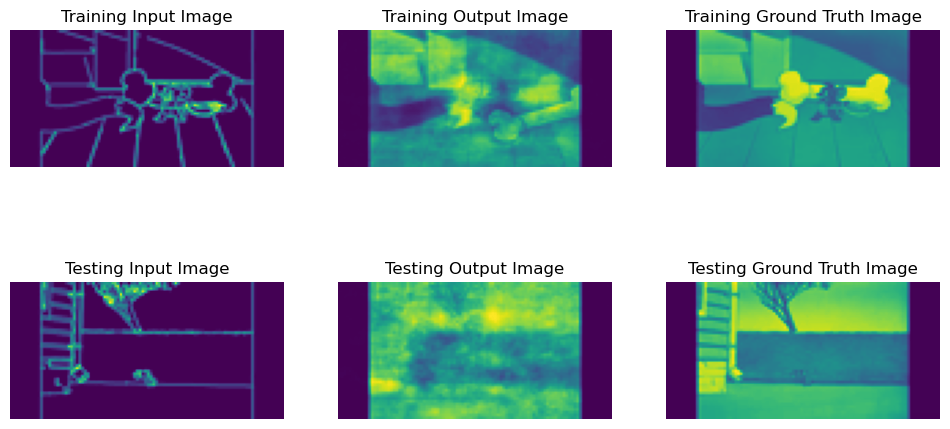

In [41]:

trainImageIndex = random.randint(0, len(x_train)-1)
testImageIndex = random.randint(0, len(x_test)-1)
train_output_image = cnn.predict(x_train)[trainImageIndex]
test_output_image = cnn.predict(x_test)[testImageIndex]

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(np.array(x_train[trainImageIndex]))
plt.title("Training Input Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.array(train_output_image))
plt.title("Training Output Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.array(y_train[trainImageIndex]))
plt.title("Training Ground Truth Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.array(x_test[testImageIndex]))
plt.title("Testing Input Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.array(test_output_image))
plt.title("Testing Output Image")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.array(y_test[testImageIndex]))
plt.title("Testing Ground Truth Image")
plt.axis('off')

plt.show()

In [42]:
cnn.save('/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/src/SavedModels/CNN.keras')